## Analysis Boston Dataset using Pyspark

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession

In [7]:
spark=SparkSession.builder.appName('Hive').getOrCreate()

In [8]:
spark

### Read the given CSV file in a Hive table 


### Read the data from Hive table as spark dataframe

In [9]:
emp = spark.read.csv('C:/Users/admin/Desktop/Imarticus/Big Data Hadoop _ Spark Exam/Dataset/boston.csv',header='true', 
                      inferSchema='true')
emp.show(5)

+-----------+----+-----------+----+-----------+-----------+-----------+-----------+---+---+-----------+-----------+-----------+-----------+
|       CRIM|  ZN|      INDUS|CHAS|        NOX|         RM|        AGE|        DIS|RAD|TAX|         PT|          B|      LSTAT|         MV|
+-----------+----+-----------+----+-----------+-----------+-----------+-----------+---+---+-----------+-----------+-----------+-----------+
|    0.00632|18.0|2.309999943|   0|0.537999988|6.574999809|65.19999695|4.090000153|  1|296|15.30000019|396.8999939|4.980000019|       24.0|
|0.027310001| 0.0|7.070000172|   0|0.469000012|6.421000004|78.90000153|4.967100143|  2|242|17.79999924|396.8999939|9.140000343|21.60000038|
|    0.02729| 0.0|7.070000172|   0|0.469000012|7.184999943|61.09999847|4.967100143|  2|242|17.79999924|392.8299866| 4.03000021|34.70000076|
|0.032370001| 0.0|2.180000067|   0|0.458000004|6.998000145|45.79999924|6.062200069|  3|222|18.70000076|394.6300049|2.940000057|33.40000153|
|0.069049999| 0.0|2.

### Get the correlation between dependent and independent variables

In [10]:
import six
for i in emp.columns:
    if not( isinstance(emp.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, emp.stat.corr('MV',i))

Correlation to MV for  CRIM -0.3883046116575088
Correlation to MV for  ZN 0.36044534463752903
Correlation to MV for  INDUS -0.48372517128143383
Correlation to MV for  CHAS 0.17526017775291847
Correlation to MV for  NOX -0.4273207763683772
Correlation to MV for  RM 0.695359937127267
Correlation to MV for  AGE -0.37695456714288667
Correlation to MV for  DIS 0.24992873873512172
Correlation to MV for  RAD -0.3816262315669168
Correlation to MV for  TAX -0.46853593528654536
Correlation to MV for  PT -0.5077867038116085
Correlation to MV for  B 0.3334608226834164
Correlation to MV for  LSTAT -0.7376627294671615
Correlation to MV for  MV 1.0


In [11]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PT', 'B', 'LSTAT'], outputCol = 'features')


In [15]:
vhouse_df = vectorAssembler.transform(emp)
vhouse_df

DataFrame[CRIM: double, ZN: double, INDUS: double, CHAS: int, NOX: double, RM: double, AGE: double, DIS: double, RAD: int, TAX: int, PT: double, B: double, LSTAT: double, MV: double, features: vector]

In [16]:
vhouse_df =vhouse_df.select(['features', 'MV'])
vhouse_df.show(3)

+--------------------+-----------+
|            features|         MV|
+--------------------+-----------+
|[0.00632,18.0,2.3...|       24.0|
|[0.027310001,0.0,...|21.60000038|
|[0.02729,0.0,7.07...|34.70000076|
+--------------------+-----------+
only showing top 3 rows



### Build a linear regression model to predict house price

In [17]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### Linear Regression Model

In [18]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.06284902566899833,0.002698801811261264,0.0,3.484220960853243,-2.3170010030810446,4.4178728702029915,0.0,-0.47879159961283463,0.0,0.0,-0.7407192262358648,0.007846610376972775,-0.5995908537049001]
Intercept: 16.257743370146855


### RMSE and R-squared values

In [36]:
trainingSummary = lr_model.summary
r2_value=trainingSummary.r2
print("r2_value :",r2_value  )
RMSE_score=trainingSummary.rootMeanSquaredError
print("RMSE_score :", RMSE_score)

r2_value : 0.7175940589671639
RMSE_score : 4.928952316874904


In [37]:
df_file= pd.DataFrame()
df_file['Model'] = ['RMSE','R-Squared Value']
df_file['Accuracy Score'] = [RMSE_score,r2_value]
df_file

,Model,Accuracy Score
0,RMSE,4.928952
1,R-Squared Value,0.717594


<BarContainer object of 2 artists>

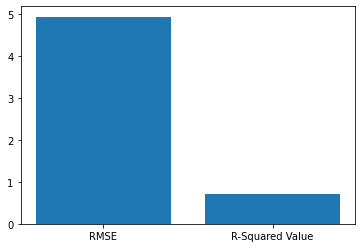

In [39]:
import matplotlib.pyplot as plt
plt.bar(x=df_file['Model'],height=df_file['Accuracy Score'])


In [20]:
train_df.describe().show()

+-------+------------------+
|summary|                MV|
+-------+------------------+
|  count|               365|
|   mean|22.609041109479453|
| stddev| 9.287812572134428|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [22]:
lr_pred = lr_model.transform(test_df)
lr_pred.select("prediction","MV","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_eval = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_eval.evaluate(lr_pred ))

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
| 30.44589553027895|32.20000076|[0.00906,90.0,2.9...|
| 27.66613713132275|       24.5|[0.01501,80.0,2.0...|
| 42.37491554088944|       50.0|[0.01501,90.0,1.2...|
|26.176454229714864|24.70000076|[0.02055,85.0,0.7...|
| 28.97557045122967|30.79999924|[0.027629999,75.0...|
+------------------+-----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.690535


In [23]:
result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" %  result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.982


In [24]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.5000000000000004, 0.43466911030374783, 0.24227814433099276, 0.21612025036219398, 0.18238826493101462, 0.17929612299796802, 0.1785729804567798, 0.17793370324775437, 0.17700321866913502, 0.17674374504467402, 0.1766474854735713]


C:\Users\admin\anaconda3\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------------+
|           residuals|
+--------------------+
| -6.9439864929212405|
|  -5.343612597286118|
| 0.42813135192142937|
|  5.0088370477277735|
|  2.2716476061409736|
|  11.772424503442068|
| 0.36949826868293556|
| -1.3617798338030944|
|   9.126780095744508|
|  2.9067042672215955|
|  1.7085542601563475|
|  -3.099174584964043|
|   6.210119231854119|
|-0.09848398518877488|
|  10.959400854079504|
|   5.815445655391102|
| 0.03171800864151919|
|  -10.54428420733225|
|  -3.993345684946174|
|   2.685204621482022|
+--------------------+
only showing top 20 rows



In [25]:
pred = lr_model.transform(test_df)
pred.select("prediction","MV","features").show()

+------------------+-----------+--------------------+
|        prediction|         MV|            features|
+------------------+-----------+--------------------+
| 30.44589553027895|32.20000076|[0.00906,90.0,2.9...|
| 27.66613713132275|       24.5|[0.01501,80.0,2.0...|
| 42.37491554088944|       50.0|[0.01501,90.0,1.2...|
|26.176454229714864|24.70000076|[0.02055,85.0,0.7...|
| 28.97557045122967|30.79999924|[0.027629999,75.0...|
|26.845917882265294|       25.0|[0.028750001,28.0...|
|20.221234035152413|       18.5|[0.030409999,0.0,...|
|30.516636154886804|34.90000153|[0.031500001,95.0...|
| 30.69052765039332|33.40000153|[0.032370001,0.0,...|
| 27.48381132653884|24.10000038|[0.034449998,82.5...|
|28.434185659501622|27.89999962|[0.036150001,80.0...|
|23.892391427899476|20.70000076|[0.037379999,0.0,...|
|24.415540794757376|20.60000038|[0.042939998,28.0...|
| 22.98433326465843|20.60000038|[0.04527,0.0,11.9...|
|24.443837486876276|19.79999924|[0.04544,0.0,3.24...|
|  25.8210169217394|23.29999

In [26]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'MV')
dt_model = dt.fit(train_df)
dt_pred = dt_model.transform(test_df)
dt_eval = RegressionEvaluator(
    labelCol="MV", predictionCol="prediction", metricName="rmse")
rmse = dt_eval.evaluate(dt_pred)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.93032
